# Create a large cutout of coadded images

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact authors: Christina Williams, Melissa Graham <br>
Last verified to run: 2024-05-13 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: Large <br>
Targeted learning level: Intermediate <br>

**Description:** Create a large custom `deepCoadd` cutout.

**Skills:** Identify tracts and patches and combine them into a large custom `deepCoadd` cutout.

**LSST Data Products:** deepCoadd_calexp

**Packages:** lsst.ip.diffim.GetTemplateTask, lsst.afw.geom.makeSkyWcs

**Credit:** Thanks to Aline Chu for raising in the Rubin Community Forum the issue of how to create patch- and tract-spanning cutouts. Thanks to Gregory Dubois-Felsmann and Lauren MacArthur who helped in the Forum, and John Parejko and Yusra Al-Sayyad for help with the LSST science pipelines.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

At the moment, the image cutout service demonstrated in DP0.2 tutorial notebook
13a must be passed a tract and patch, and can only create a cutout from a single
patch.

This will always be a contraint for single processed visit images (PVIs,
also known as `calexp`s).
In the future, users will be able to request `deepCoadd` cutouts from the 
Rubin image cutout service which span patch and tract boundaries.

In the meantime, this tutorial demonstrates how to use the `GetTemplateTask`
to create a single cutout image with contributions from multiple adjacent
patches and tracts. 

In the LSST Science Pipelines, `GetTemplateTask` is used to create a template
image from `deepCoadd` images for a given PVI, in order to perform Difference Image Analysis.

As described in the documentation for
<a href="https://pipelines.lsst.io/modules/lsst.ip.diffim/tasks/lsst.ip.diffim.GetTemplateTask.html">GetTemplateTask</a>
and its
<a href="https://pipelines.lsst.io/py-api/lsst.ip.diffim.GetTemplateTask.html#lsst.ip.diffim.GetTemplateTask.run">run method</a>,
the function of this task is to:

> *Build a template from existing coadds, which may span multiple tracts. The assembled template inherits the WCS of the selected skymap tract and the resolution of the template exposures. Overlapping box regions of the input template patches are pixel by pixel copied into the assembled template image. There is no warping or pixel resampling. Pixels with no overlap of any available input patches are set to nan value and NO_DATA flagged.*

>*Where the tracts overlap, the resulting template image is averaged. The PSF on the template is created by combining the CoaddPsf on each template image into a meta-CoaddPsf.*

**Related tutorials:**
This tutorial assumes some familiarity with the following concepts.
DP0.2 tutorial notebooks that demonstrate these concepts more fully are listed in parentheses.
It is not necessary to run through all of these other tutorials before doing this one,
but they might be useful as reference.

 * the butler (04a, 04b)
 * the TAP service (02)
 * image display (03a, 03b)

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

### 1.1. Import packages

Import packages from the LSST Science Pipelines (top) and 
general python packages (bottom).

In [2]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.rsp import get_tap_service, retrieve_query
from lsst.daf.butler import Butler, CollectionType
from lsst.ip.diffim import GetTemplateTask
from lsst.afw.image import Image
from lsst.afw.geom import makeSkyWcs

import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

from photutils.aperture import SkyCircularAperture, RectangularAperture, SkyRectangularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord


### 1.2. Define functions and parameters

Set the `afwDisplay` backend to `matplotlib`.

In [3]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service.

In [4]:
service = get_tap_service("tap")

Instantiate the butler.

In [5]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

## 2. Prepare to create the cutout

### 2.1. Define central coordinates and box size

Define the central coordinates and the size of the side of the desired cutout.

For this example, the coordinates 50.5265, -39.7589 are known to be near the intersection of patches and tracts.

The size of the cutout will be constrained by the container size selected
when the Notebook Aspect session was started, because all the images
that contribute to the cutout must be held in memory simultaneously
and passed to `GetTemplateTask` (this will become clear in Section 3).

In [6]:
my_ra = 50.5265
my_dec = -39.7589
box_side_deg = 0.2

Define the extent of the cutout in RA and Dec. Include the `cos(dec)` factor.

In [7]:
ra1 = my_ra + 0.5 * box_side_deg / np.cos(np.radians(my_dec))
ra2 = my_ra - 0.5 * box_side_deg / np.cos(np.radians(my_dec))
dec1 = my_dec - 0.5 * box_side_deg
dec2 = my_dec + 0.5 * box_side_deg
print('ra1 = %8.4f,  ra2 = %8.4f,  delta RA = %6.3f' %
      (ra1, ra2, np.abs(ra2-ra1)))
print('dec1 = %8.4f, dec2 = %8.4f, delta Dec = %6.3f' %
      (dec1, dec2, np.abs(dec2-dec1)))

ra1 =  50.6566,  ra2 =  50.3964,  delta RA =  0.260
dec1 = -39.8589, dec2 = -39.6589, delta Dec =  0.200


Define corners of the cutout.

The order is: SE, SW, NW, NE, as drawn in the plot above.

In [8]:
corners = np.asarray([[ra1, dec1], [ra2, dec1],
                      [ra2, dec2], [ra1, dec2]],
                     dtype='float')

Option to create a little plot to visualize the corners.

Note that the figure is forced to 3:2 dimensions size.

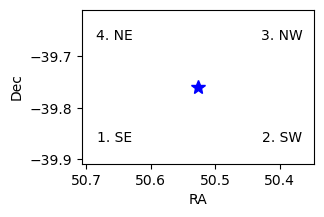

In [9]:
fig = plt.figure(figsize=(3, 2))
plt.plot(my_ra, my_dec, '*', ms=10, color='blue')
clabels = ['1. SE', '2. SW', '3. NW', '4. NE']
for corner, clabel in zip(corners, clabels):
    plt.text(corner[0], corner[1], clabel, ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim([ra1+0.05, ra2-0.05])
plt.ylim([dec1-0.05, dec2+0.05])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

### 2.2. Identify nearest patch to use as anchor image

Use the butler to find the tract and patch within which
the central coordinates of the desired cutouts are most centered.

This will be the tract and patch used as the "anchor image"
when creating the big cutout.


In [10]:
my_point = geom.SpherePoint(my_ra * geom.degrees,
                            my_dec * geom.degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_point)
patch = tract.findPatch(my_point)
anchor_tract = tract.tract_id
anchor_patch = patch.getSequentialIndex()
print('anchor tract and patch: ', anchor_tract, anchor_patch)
del my_point, skymap, tract, patch

anchor tract and patch:  3442 13


### 2.3. Identify additional tracts and patches

In the future, it will be possible to write ADQL statements
that use the INTERSECTS functionality to identify all patches
(or images) that overlap with a defined polygon.

For now, use the TAP service to search the `coaddPatches` table
for images with central coordinates that indicate the patch
could *potentially* overlap with the defined extent of the 
desired cutout.

Increase the extent of the search by the patch size to make sure
no overlapping patch is missed.
This may well end up identifying a few patches that do not, in the end,
overlap with the extent of the desired cutout -- and that's ok.

In [11]:
sra1 = ra1 + 0.22
sra2 = ra2 - 0.22
sdec1 = dec1 - 0.22
sdec2 = dec2 + 0.22

scorners = np.asarray([[sra1, sdec1], [sra2, sdec1],
                       [sra2, sdec2], [sra1, sdec2]],
                      dtype='float')

Create the TAP query.

In [12]:
string_polygon = ""
for c, scorner in enumerate(scorners):
    s1 = str(np.round(scorner[0], 4))
    s2 = str(np.round(scorner[1], 4))
    string_polygon += s1 + ', ' + s2
    if c < 3:
        string_polygon += ', '
    del s1, s2

query = "SELECT lsst_patch,lsst_tract,s_dec,s_ra "\
        "FROM dp02_dc2_catalogs.CoaddPatches "\
        "WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), "\
        "POLYGON('ICRS', "+string_polygon+"))=1"
print(query)

SELECT lsst_patch,lsst_tract,s_dec,s_ra FROM dp02_dc2_catalogs.CoaddPatches WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), POLYGON('ICRS', 50.8766, -40.0789, 50.1764, -40.0789, 50.1764, -39.4389, 50.8766, -39.4389))=1


Run the TAP query.

In [13]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


If the returned job phase was "error", uncomment the following to review the error.

In [14]:
# job.raise_if_error()

Retrieve the TAP results.

In [15]:
results = job.fetch_result().to_table()

Option to show the results.

In [16]:
# results

Hold the tract and patch values for images that 
will contribute, in addition to the anchor image,
to the final custom cutout in `add_tracts_and_patches`.

In [17]:
temp = []
for result in results:
    tract = result['lsst_tract']
    patch = result['lsst_patch']
    if (tract != anchor_tract) | (patch != anchor_patch):
        temp.append([tract, patch])
add_tracts_and_patches = np.asarray(temp, dtype='int')
del temp

print('add these to the anchor patch: ')
print(add_tracts_and_patches)

add these to the anchor patch: 
[[3442   19]
 [3441    7]
 [3441   14]
 [3442   20]
 [3442   12]]


## 3. Create the custom cutout

Define the filter of the desired custom cutout.

In [18]:
use_filter = 'r'

Define the `dataId` for the anchor image.

Use the butler to retrieve the anchor image and its World Coordinate System (WCS).

In [19]:
anchor_dataId = {'tract': anchor_tract, 'patch': anchor_patch,
                 'band': use_filter}
anchor_image = butler.get('deepCoadd_calexp', dataId=anchor_dataId)
anchor_wcs = butler.get('deepCoadd_calexp.wcs', dataId=anchor_dataId)
print(anchor_wcs)

FITS standard SkyWcs:
Sky Origin: (51.4285714286, -39.4214876033)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


Visually inspect the `anchor_image`. The below demonstration plots a circle centered at `my_ra` and `my_dec`, with diameter equal to the desired image box edge outlined above. The map indicates that the desired location is near the patch and tract edge and joining to other deepCoadds is required in order to display a contiguous image. 

(<matplotlib.patches.Circle at 0x7abbfdfe5a50>,)

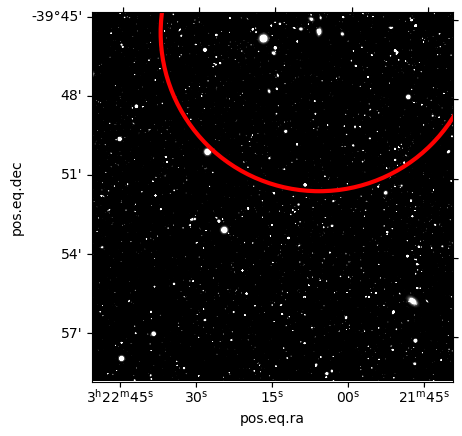

In [20]:
radius = box_side_deg/2. * u.deg
coord = SkyCoord(ra=my_ra*u.degree, dec=my_dec*u.degree, frame='icrs')

 
plt.subplot(projection=WCS(anchor_image.getWcs().getFitsMetadata()))
extent = (anchor_image.getBBox().beginX, anchor_image.getBBox().endX,
          anchor_image.getBBox().beginY, anchor_image.getBBox().endY)

plt.imshow(anchor_image.image.array, vmin=.1, vmax=1, extent=extent,
           origin='lower', cmap='gray')

anchor_bbox = anchor_image.getBBox()


aperture = SkyCircularAperture(coord, r=radius)
pix_aperture = aperture.to_pixel(WCS(anchor_image.getWcs().getFitsMetadata()))
pix_aperture.plot(color='r', lw=3)


Create the arrays of `dataId`s and images to be passed to `GetTemplateTask`.

In [21]:
all_dataIds = [anchor_dataId]
all_images = [anchor_image]
for i in range(len(add_tracts_and_patches)):
    temp_tract = add_tracts_and_patches[i][0]
    temp_patch = add_tracts_and_patches[i][1]
    temp_dataId = {'tract': temp_tract, 'patch': temp_patch,
                   'band': use_filter}
    temp_image = butler.get('deepCoadd_calexp', dataId=temp_dataId)

    all_images.append(temp_image)
    all_dataIds.append(temp_dataId)
    del temp_tract, temp_patch, temp_dataId, temp_image

Option to print the `dataId`s.

In [22]:
for dataId in all_dataIds:
    print(dataId)

{'tract': 3442, 'patch': 13, 'band': 'r'}
{'tract': 3442, 'patch': 19, 'band': 'r'}
{'tract': 3441, 'patch': 7, 'band': 'r'}
{'tract': 3441, 'patch': 14, 'band': 'r'}
{'tract': 3442, 'patch': 20, 'band': 'r'}
{'tract': 3442, 'patch': 12, 'band': 'r'}


Define `getTemplateTask`. 

No configuration changes are needed.

In [23]:
getTemplateTask = GetTemplateTask()


Build the WCS definition for the new cutout. There are two sub-use cases. 

If the desired cutout crosses patch boundaries but is within a single tract, then the pixel grids are exactly compatible, and no reprojection is needed. Pixels from adjacent patches can be exactly stitched together at the boundaries, without having to re-define a WCS and reproject the pixels onto it.  Pixels can be taken from the relevant patches and stitched into a single array.  If not reprojecting, careful to preserve the CRPIX/CRVAL values of the inputs and not attempt to recenter the WCS on the cutout, because it's still on a tangent plane relative to the tract center.

However, if the cutout crosses tract boundaries (which have independent projections and WCS), then one must reproject the input images to a new tangent plane centered at the target and with north up. This more general case is demonstrated below, and will work also for the simpler case of adjacent patches within one tract.

The cell below defines the new WCS for the joined images across both patch and tract boundaries.  The WCS consists of 4 components: 1) the ra and dec of the center of the image defined as `crval`;  2) the center pixel (x, y) defined as `crpix`. In Section 1, the cutout area of interest is defined in `box_side_deg` as 0.2 degrees on a side (12 arcminutes). The center is defined as `box_side_deg` converted to arcsec and then divided in half; dividing that by the deepCoadd pixel scale of 0.2 arcsec/pixel then allows us to find the center pixel of the resulting area of sky; 3) the pixel scale, which is a 2x2 matrix defined as `cdMatrix`; 4) the projection of the WCS `projection`, which is defined as `TAN` (referring to a new tangent projection centered at the `crval`). Note that the pixel scale of all deepCoadds are always the same; the new WCS can thus recycle the one from `anchor_image`.

In [24]:
crval = geom.SpherePoint(my_ra, my_dec, geom.degrees)

crpix = box_side_deg * 3600 / 2. / 0.2
crpix1 = crpix
crpix2 = crpix
crpix = geom.Point2D(crpix1, crpix2)

x = anchor_image.getWcs().getFitsMetadata()
cdMatrix = [x['CD1_1'], x['CD1_2']], [x['CD2_1'], x['CD2_2']]

projection = 'TAN'


Define the new WCS for the large cutout using the `makeSkyWcs` method based on the definition above.

In [25]:
newWCS = makeSkyWcs(crpix, crval, cdMatrix, projection)
print(newWCS)
print(anchor_image.getWcs())

FITS standard SkyWcs:
Sky Origin: (50.5265000000, -39.7589000000)
Pixel Origin: (1800, 1800)
Pixel Scale: 0.2 arcsec/pixel
FITS standard SkyWcs:
Sky Origin: (51.4285714286, -39.4214876033)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


Create a bounding box for the new image.

In [26]:
corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
corner_SE_pix = newWCS.skyToPixel(corner_SE_deg)
corner_NW_pix = newWCS.skyToPixel(corner_NW_deg)

xmin = int(np.floor(corner_SE_pix[0]))
ymin = int(np.floor(corner_SE_pix[1]))
xmax = int(np.floor(corner_NW_pix[0]))
ymax = int(np.floor(corner_NW_pix[1]))

newimg_shape = Image(geom.Box2I(minimum=geom.Point2I(x=xmin, y=ymin),
                                maximum=geom.Point2I(x=xmax, y=ymax)),
                     dtype=np.float32)
newimage_bbox = newimg_shape.getBBox()


In [28]:
#import regions

Create the custom cutout as `newimage`.

>**Notice:** Some input patch images might be skipped for not, in the end, overlapping with the defined bounding box after all. This was expected, as described in Section 2.3. 

In [27]:
newimage = getTemplateTask.run(all_images, newimage_bbox,
                               newWCS, all_dataIds)



TypeError: GetTemplateTask.run() missing 1 required positional argument: 'physical_filter'

## 4. Visualize the custom cutout

Extract metadata for the custom cutout.

In [ ]:
newimage_wcs = newimage.template.getWcs()
newimage_wcs_fmd = newimage.template.getWcs().getFitsMetadata()

newimage_extent = (newimage_bbox.beginX, newimage_bbox.endX,
                   newimage_bbox.beginY, newimage_bbox.endY)

### 4.1. Display with matplotlib

Compare the red circle in the larger cutout to that from the `anchor_image` in the last section.

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(projection=WCS(newimage_wcs_fmd))
plt.imshow(newimage.template.image.array, vmin=0.01, vmax=0.5,
           extent=newimage_extent, origin='lower', cmap='gray')

aperture = SkyCircularAperture(coord, r=radius)
pix_aperture = aperture.to_pixel(WCS(newimage_wcs_fmd))
pix_aperture.plot(color='r', lw=3)






###### TRYING TO EDIT FOR MAKING PATCH/TRACT BOXES:
#corners2 = anchor_wcs.pixelToSky(anchor_bbox.beginX, anchor_bbox.beginY)
#corners = SkyCoord(ra=corners1.getRa(), dec=corners.getDec(), unit='deg')

#region_sky = PolygonSkyRegion(vertices=vertices)

corners1 = [anchor_wcs.pixelToSky(anchor_bbox.beginX, anchor_bbox.beginY),
           anchor_wcs.pixelToSky(anchor_bbox.beginX, anchor_bbox.endY),
           anchor_wcs.pixelToSky(anchor_bbox.endX, anchor_bbox.endY),
           anchor_wcs.pixelToSky(anchor_bbox.endX, anchor_bbox.beginY)]

#print(corners1, anchor_bbox)
corners_anchor_sky = geom.SpherePoint(corners1[0].getRa().asDegrees(), corners1[0].getDec().asDegrees(), geom.degrees)
                      #[corners1[0].getRa().asDegrees(), corners1[0].getDec().asDegrees()],
                      #[corners1[0].getRa().asDegrees(), corners1[0].getDec().asDegrees()],
                      #[corners1[0].getRa().asDegrees(), corners1[0].getDec().asDegrees()]], geom.degrees)

#corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
#corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
#corner_SE_pix = newWCS.skyToPixel(corner_SE_deg)
#corner_NW_pix = newWCS.skyToPixel(corner_NW_deg)

corners_anchor_pix = newWCS.skyToPixel(corners_anchor_sky)
extent1 = [(anchor_image.getBBox().endX-anchor_image.getBBox().beginX)/2. + anchor_image.getBBox().beginX,
           (anchor_image.getBBox().endY-anchor_image.getBBox().beginY)/2. + anchor_image.getBBox().beginY]
print(anchor_image.getBBox(), anchor_image.getBBox().beginX)
anchor_bbox = anchor_image.getBBox()
print(corners_anchor_sky)
aper = RectangularAperture(extent1,anchor_image.getBBox().endX-anchor_image.getBBox().beginX , anchor_image.getBBox().endY-anchor_image.getBBox().beginY)
aper.plot(color='b',lw=3)


#vertices = SkyCoord([1, 2, 2], [1, 1, 2], unit='deg', frame='fk5')
#vertices = SkyCoord(corners_anchor_sky[0,:],corners_anchor_sky[1,:], unit='deg', frame='fk5')

#from matplotlib.patches import Polygon
#extent_poly = [[anchor_image.getBBox().beginX+10, anchor_image.getBBox().beginY-10],
#               [anchor_image.getBBox().beginX+10, anchor_image.getBBox().endY-10],
#               [anchor_image.getBBox().endX, anchor_image.getBBox().endY],
#               [anchor_image.getBBox().beginY, anchor_image.getBBox().endX]]
#r = Polygon(extent_poly, color='b')
#ax = plt.gca()
#ax.add_patch(r)

######


plt.show()

### 4.2. Display with `afwDisplay`

In [ ]:
fig = plt.figure(figsize=(8, 8))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(newimage.template.image)
plt.show()

### 4.3. Display with Firefly

Firefly allows for interactive image display and manipulation.
See DP0.2 tutorial notebook 03b for a full demonstration of how to use Firefly within the Notebook Aspect.

Reset the `afwDisplay` backend to be Firefly and start the display.
A new tab will open, containing the Firefly interface.

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Display the image in Firely.

In [ ]:
afw_display.mtv(newimage.template)

The Firefly default is to visualize the mask plane with colors. 
Set the mask plane transparency to 100, fully transparent, to see only the pixel data.

In [ ]:
afw_display.setMaskTransparency(100)

### 4.4. Option to save as a FITS file

Save as a FITS file in the home directory.

> **Warning:** Images can take up a lot of disk space. Save and download with caution.

In [ ]:
username = os.environ.get('USER')
fnm = '/home/' + username + '/my_big_cutout.fits'
newimage.template.writeFits(fnm)
del username, fnm

## 5. PSF stuff


NOTES:

x - check that ra/dec of sources on outskirts are still at the right location

- get the PSF. it comes with the image i got and ask it to provide the PSF for the x,y coordinates you're interested in. you might see some discontinuity in the PSF size FWHM.

- ask it: gimme PSF at this point and the FWHM comes from butler. Andres has a tutorial notebook, just first one is fine. display image you put together and draw on the boundaries of which tract patch (and label and draw lines on it)

- release notebook and call this done after that step is completed. 
try aaron for this review, if not, then jeff

- PSF is stretch goal,

From end of: https://pipelines.lsst.io/py-api/lsst.ip.diffim.GetTemplateTask.html#lsst.ip.diffim.GetTemplateTask
 run(coaddExposures, bbox, wcs, dataIds, physical_filter=None, **kwargs)

    Warp coadds from multiple tracts to form a template for image diff.

    Where the tracts overlap, the resulting template image is averaged. The PSF on the template is created by combining the CoaddPsf on each template image into a meta-CoaddPsf.

In [ ]:
print(all_images)
from lsst.geom import Point2D
import sys

center = geom.SpherePoint(my_ra, my_dec, geom.degrees)
SIGMA_TO_FWHM = 2.0*np.sqrt(2.0*np.log(2.0))

# first, compare the PSF at the source in the anchor image to that in the joined cutout
anchor_info = anchor_image.getInfo()
center_pix_anchor = anchor_wcs.skyToPixel(center) #corner_SE_deg)
newimage_info = newimage.template.getInfo() 
center_pix_newimage = newWCS.skyToPixel(center) #corner_SE_deg)
point_tuple = (center_pix_anchor[0],center_pix_anchor[1])
point_image = Point2D(point_tuple)
anchor_psf = anchor_image.getPsf()
psf_shape = anchor_psf.computeShape(point_image)
psf_shape
psf_sigma = psf_shape.getDeterminantRadius()
psf_fwhm = psf_sigma * SIGMA_TO_FWHM
print("anchor center sigma=",psf_sigma, "FWHM=",psf_fwhm)



newimage_psf = newimage.template.getPsf()
print(newimage_psf)
point_tuple = (center_pix_newimage[0],center_pix_newimage[1])
point_image = Point2D(point_tuple)
psf_shape = newimage_psf.computeShape(point_image)
psf_sigma = psf_shape.getDeterminantRadius()
psf_fwhm = psf_sigma * SIGMA_TO_FWHM
print("newimage center sigma=",psf_sigma, "FWHM=",psf_fwhm)


center_pix = anchor_wcs.skyToPixel(corner_SE_deg)
point_tuple = (center_pix[0],center_pix[1])
point_image = Point2D(point_tuple)
psf_shape = anchor_psf.computeShape(point_image)
psf_sigma = psf_shape.getDeterminantRadius()
psf_fwhm = psf_sigma * SIGMA_TO_FWHM
print("anchor SE corner sigma=",psf_sigma, "FWHM=",psf_fwhm)



center_pix = newWCS.skyToPixel(corner_SE_deg)
point_tuple = (center_pix[0],center_pix[1])
point_image = Point2D(point_tuple)
psf_shape = newimage_psf.computeShape(point_image)
psf_sigma = psf_shape.getDeterminantRadius()
psf_fwhm = psf_sigma * SIGMA_TO_FWHM
print("newimage SE corner sigma=",psf_sigma, "FWHM=",psf_fwhm)
